In [1]:
import warnings
warnings.filterwarnings("ignore")

from data_loader import load_data_from_disk, process_to_df, cut_light_change
from draw import plot_per_light_cuts, plot_pupil_ci, plot_pupil_ci_subplots, rgb_color_names

import os
import matplotlib.pyplot as plt

In [2]:
# TEST_GROUP={
#     "type" : "单色1",
#     "time" : 1,
#     "start" : 1,
#     "duration" : 3,
#     "step" : 2
# }
# TEST_GROUP={
#     "type" : "单色3",
#     "time" : 3,
#     "start" : 3,
#     "duration" : 9,
#     "step" : 6
# }
TEST_GROUP={
    "type" : "单色5",
    "time" : 5,
    "start" : 5,
    "duration" : 15,
    "step" : 10
}
# TEST_GROUP={
#     "type" : "单色p5",
#     "time" : 0.5,
#     "start" : 0.5,
#     "duration" : 1.5,
#     "step" : 1
# }

In [3]:
if not os.path.exists(f"exp-1-pic\\{TEST_GROUP['type']}"):
    os.mkdir(f"exp-1-pic\\{TEST_GROUP['type']}")

light_data = load_data_from_disk(
    "E:\LightYourEyesData\实验一",
    data_type="light_changes",
    test_type=TEST_GROUP['type'],
    test_times=1
)

light_df = process_to_df(
    light_data,
    smooth_win=int(0.5*TEST_GROUP['time']*50)
)

In [4]:
cutted_data = cut_light_change(
    light_df,
    start_time=TEST_GROUP['start'],
    duration=TEST_GROUP['duration'],
    step=TEST_GROUP['step']
)

In [5]:
from draw import plot_per_subject

fig = plot_per_subject(light_df, time_interval=TEST_GROUP['time'], sampling_rate=50, figsize=(12, 50)) 
fig.savefig(os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}", f"allpupil.png"),
            dpi=200
            )
plt.close()

In [5]:
# for i,cut in enumerate(cutted_data):
#     fig = plot_per_light_cuts(
#         cut["data"],
#         title=f"{cut['start_energy']} ({cut['start_rgb']}) -> { cut['end_energy'] } ({cut['end_rgb']})",
#         time_interval=TEST_GROUP['time'],
#     )
#     fig.savefig(
#         os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}", f"{i}.png"),
#         dpi=200
#     )
#     plt.close()

In [6]:
samestart_cluster = {}

for cut in cutted_data:
    s_rgb = "-".join(str(n) for n in cut["start_rgb"])
    e_rgb = "-".join(str(n) for n in cut["end_rgb"])
    if s_rgb in samestart_cluster:
        if e_rgb in samestart_cluster[s_rgb]:
            samestart_cluster[s_rgb][e_rgb].append(cut["data"])
        else:
            samestart_cluster[s_rgb][e_rgb] = [cut["data"]]
    else:
        samestart_cluster[s_rgb] = {}
        samestart_cluster[s_rgb][e_rgb] = [cut["data"]]

In [7]:
import numpy as np

trans_subtraction = {}
for start in samestart_cluster.keys():
    if start not in rgb_color_names.keys(): continue
    trans_subtraction[rgb_color_names[start]] = {}
    for end in samestart_cluster[start].keys():
        subs = []
        for _d in samestart_cluster[start][end]:
            trans_s = int(TEST_GROUP["time"]*50)
            trans_e = int(TEST_GROUP["time"]*2*50)

            subs.append(np.mean(_d["leftPD"][trans_e-3 :trans_e+4]) - np.mean(_d["leftPD"][trans_s-3 : trans_s+4]))
            subs.append(np.mean(_d["rightPD"][trans_e-3 :trans_e+4]) - np.mean(_d["rightPD"][trans_s-3 : trans_s+4]))
        # trans_subtraction[rgb_color_names[start]][rgb_color_names[end]] = np.mean(subs)
        trans_subtraction[rgb_color_names[start]][rgb_color_names[end]] = subs

    fig = plot_pupil_ci(
            samestart_cluster[start],
            title = f"Transition Start with Color {rgb_color_names[start]}",
            time_interval=TEST_GROUP['time'],
            change_start=TEST_GROUP['time']
        )
    fig.savefig(
        os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}", f"{rgb_color_names[start]}.png"),
        dpi=200
    )
    plt.close()

    fig = plot_pupil_ci_subplots(
            samestart_cluster[start],
            start_color=start,
            title = f"Transition Start with Color {rgb_color_names[start]}",
            time_interval=TEST_GROUP['time'],
            change_start=TEST_GROUP['time']
        )
    fig.savefig(
        os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}", f"{rgb_color_names[start]}-subplots.png"),
        dpi=200
    )
    plt.close()

In [8]:
import pandas as pd
from draw import rgb_color_names
trans_diff = pd.DataFrame(trans_subtraction)
# trans_diff.index = [rgb_color_names[i] for i in trans_diff.index]
# trans_diff.columns = [rgb_color_names[i] for i in trans_diff.columns]
trans_diff.to_csv(os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}-transdiff.csv"))

In [9]:
from draw import rgb_color_names
from Light import rgb_to_energy_spectral, str_to_rgb
rgb_energydiff = {}

for s_rgb in rgb_color_names:
    rgb_energydiff[rgb_color_names[s_rgb]] = {}
    for e_rgb in rgb_color_names:
        _sub = rgb_to_energy_spectral(str_to_rgb(e_rgb)) - rgb_to_energy_spectral(str_to_rgb(s_rgb))
        rgb_energydiff[rgb_color_names[s_rgb]][rgb_color_names[e_rgb]] = _sub

In [10]:
ener = []
amp = []
for s_rgb in rgb_color_names.values():
    for e_rgb in rgb_color_names.values():
        if e_rgb in trans_subtraction[s_rgb]:
            temp_ener = [rgb_energydiff[s_rgb][e_rgb] for _ in range(len(trans_subtraction[s_rgb][e_rgb]))]
            # ener.append(rgb_energydiff[s_rgb][e_rgb])
            # amp.append(trans_subtraction[s_rgb][e_rgb])
            ener.extend(temp_ener)
            amp.extend(trans_subtraction[s_rgb][e_rgb])
# print(len(amp))
# print(len(ener))
df = pd.DataFrame({"X":np.array(ener).reshape(-1), "Y":np.array(amp).reshape(-1)})

<Figure size 1000x600 with 0 Axes>

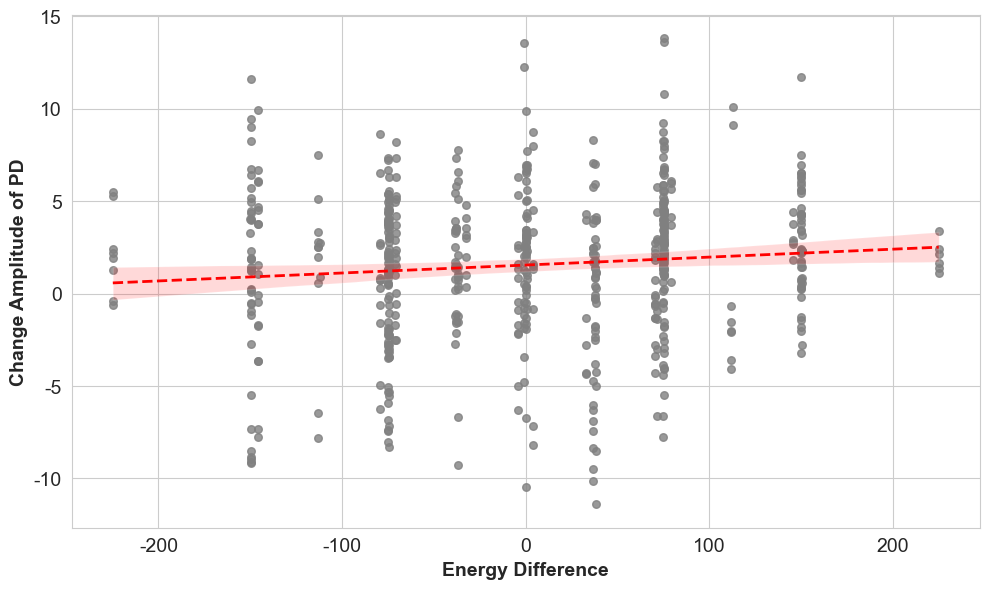

In [11]:
import seaborn as sns
plt.figure(figsize=(10, 6))

sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Use a single `regplot` call to plot both points and the regression line
# Customize the appearance of the scatter points with `scatter_kws`
# and the regression line with `line_kws`
sns.regplot(x='X', y='Y', data=df,
            scatter_kws={'color': 'gray', 'alpha': 0.8, 's': 30},
            line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2})

# Add titles and labels for clarity
# plt.title('Linear Estimation Plot', fontsize=16, fontweight='bold')
plt.xlabel('Energy Difference', fontsize=14, fontweight='bold')
plt.ylabel('Change Amplitude of PD', fontsize=14, fontweight='bold')
plt.tick_params(axis='x', labelsize=14)  # X轴刻度字体大小
plt.tick_params(axis='y', labelsize=14)  # Y轴刻度字体大小
plt.tight_layout()

plt.savefig(os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}-energydiff.png"))

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


X = df["X"].values.reshape(-1, 1)
Y = df["Y"].values.reshape(-1, 1)

import statsmodels.api as sm

# Add a constant (the intercept) to the independent variable
X_sm = sm.add_constant(X)

# Create an OLS (Ordinary Least Squares) model
model_sm = sm.OLS(Y, X_sm)
results = model_sm.fit()

# Print the full summary to get the p-value
print(results.summary())

with open(os.path.join(f"exp-1-pic\\log.txt"), "a") as f:
    f.write(f"=============={TEST_GROUP['type']}==============\n")
    f.write(results.summary().as_text())
    f.write(f"==========================================\n")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     5.481
Date:                Wed, 03 Sep 2025   Prob (F-statistic):             0.0196
Time:                        21:39:24   Log-Likelihood:                -1629.7
No. Observations:                 578   AIC:                             3263.
Df Residuals:                     576   BIC:                             3272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5399      0.169      9.107      0.0

In [13]:
from Light import rgb_to_energy_spectral, str_to_rgb

energydiff_cluster = {
    "< -100":[],
    "-100 ~ -50":[],
    "-50 ~ -25":[],
    "-25 ~ 25":[],
    "25 ~ 50":[],
    "50 ~ 100":[],
    "> 100":[]
}

for cut in cutted_data:
    s_rgb = "-".join(str(n) for n in cut["start_rgb"])
    e_rgb = "-".join(str(n) for n in cut["end_rgb"])
        
    _sub = rgb_to_energy_spectral(str_to_rgb(e_rgb)) - rgb_to_energy_spectral(str_to_rgb(s_rgb))
    if _sub<-100:
        energydiff_cluster["< -100"].append(cut["data"])
    elif -100 <= _sub < -50:
        energydiff_cluster["-100 ~ -50"].append(cut["data"])
    elif -50 <= _sub < -25:
        energydiff_cluster["-50 ~ -25"].append(cut["data"])
    elif -25 <= _sub < 25:
        energydiff_cluster["-25 ~ 25"].append(cut["data"])
    elif 25 <= _sub < 50:
        energydiff_cluster["25 ~ 50"].append(cut["data"])
    elif 50 <= _sub < 100:
        energydiff_cluster["50 ~ 100"].append(cut["data"])
    elif 100 <= _sub:
        energydiff_cluster["> 100"].append(cut["data"])

In [14]:
from draw import plot_pupil_energydiff
fig = plot_pupil_energydiff(
            energydiff_cluster,
            title = f"PD Values Grouped by Energy Transition Differences",
            time_interval=TEST_GROUP['time'],
            change_start=TEST_GROUP['time']
    )
fig.savefig(
        os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}", f"energydiff.png"),
        dpi=200
    )
plt.close()

fig = plot_pupil_energydiff(
            energydiff_cluster,
            title = f"PD Values Grouped by Transition Energy Differences",
            time_interval=TEST_GROUP['time'],
            change_start=0
    )
fig.savefig(
        os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}", f"energydiff-zerostart.png"),
        dpi=200
    )
plt.close()

In [15]:
from draw import plot_per_subject

fig = plot_per_subject(light_df, time_interval=TEST_GROUP['time'], sampling_rate=50) 
fig.savefig(os.path.join(f"exp-1-pic\\{TEST_GROUP['type']}", f"allpupil.png"),
            dpi=200
            )
plt.close()

In [16]:
from Light import rgb_to_str

def cut_by_stage(data):
    df = data.copy()
    df["skyboxColorRGB"] = df["skyboxColorRGB"].apply(rgb_to_str)
    
    # Initialize the dictionary to hold the results
    phases = {"stay": [], "transition": []}
    
    # Convert skyboxcolor to a categorical type for efficient comparison
    color_series = df['skyboxColorRGB']
    
    # Find the indices where the color changes
    transition_indices = color_series[color_series.shift(2) != color_series].index
    
    s_idx = transition_indices[0]
    e_idx = transition_indices[1]
    _idx = 1
    while _idx<len(transition_indices):
        if transition_indices[_idx] - transition_indices[_idx-1]==1:
            e_idx = transition_indices[_idx]
        else:
            phases["transition"].append(df.iloc[s_idx:e_idx+1].copy())
            phases["stay"].append(df.iloc[e_idx+1:transition_indices[_idx]].copy())
            s_idx = transition_indices[_idx]
            e_idx = transition_indices[_idx]
        _idx += 1
    phases["transition"].append(df.iloc[s_idx:transition_indices[-1]+1].copy())
    phases["stay"].append(df.iloc[transition_indices[-1]+1:].copy())
            
    return phases

In [17]:
from metrics import calculate_cv
import numpy as np

stat_res = {}
for _p in light_df:
    temp_stat = {}
    _temp = light_df[_p].loc[:, ["leftPD", "rightPD"]].mean(axis=1).values
    temp_stat["Overall-CV"] = calculate_cv(_temp)
    
    _temp_cut = cut_by_stage(light_df[_p])
    _trans_cv = []
    for _d in _temp_cut["transition"]:
        _trans_cv.append(calculate_cv(_d.loc[:, ["leftPD", "rightPD"]].mean(axis=1).values))
    _stay_cv = []
    for _d in _temp_cut["stay"]:
        _stay_cv.append(calculate_cv(_d.loc[:, ["leftPD", "rightPD"]].mean(axis=1).values))
    
    temp_stat["Overall-CV"] = calculate_cv(_temp)
    temp_stat["Trans-CV"] = np.mean(_trans_cv)
    temp_stat["Stay-CV"] = np.mean(_stay_cv)
    temp_stat["Trans-CVs"] = _trans_cv
    temp_stat["Stay-CVs"] = _stay_cv
    stat_res[_p] = temp_stat

In [18]:
import pandas as pd
import json

with open(f"exp-1-pic\\{TEST_GROUP['type']}-cv-stat.json", "w") as f:
    json.dump(stat_res, f)
pd.DataFrame(stat_res).T.iloc[:, :3].astype(np.float32).describe().to_csv(f"exp-1-pic\\{TEST_GROUP['type']}-cv-stat.csv")

In [19]:
from scipy.stats import f_oneway

def AnovaTest(_input, _col, label_col):
    groups = []
    for i in _input[label_col].unique():
        groups.append(_input[_input.loc[:, label_col] == i].loc[:, _col])
    u_statistic, p_value = f_oneway(*groups)
    return p_value

temp_d = {}
for type in ["单色p5", "单色1", "单色3", "单色5"]:
    with open(f"exp-1-pic\\{type}-cv-stat.json", "r", encoding='utf-8-sig') as f:
        sd = json.load(f)

    temp_d[type] = []
    for _, _v in sd.items():
         temp_d[type].append(_v["Overall-CV"])

In [20]:
f_oneway(*temp_d.values())

F_onewayResult(statistic=1.3121534161166686, pvalue=0.2781636519492272)